# Upper Grindelwald case study

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import netCDF4
import salem
import copy

In [11]:
import oggm
from oggm import cfg
from oggm import workflow
from oggm import utils
from oggm import graphics
from oggm.core.models import massbalance, flowline
from oggm.core.preprocessing.inversion import invert_parabolic_bed

In [3]:
cfg.initialize()  # read the default parameter file for OGGM

### Glacier directory

In [4]:
bdir = '/Users/oberrauch/bac/raw_data/grindelwald/'
gdir = utils.GlacierDirectory('RGI50-11.01270', base_dir=bdir)

In [5]:
flowline.init_present_time_glacier(gdir)

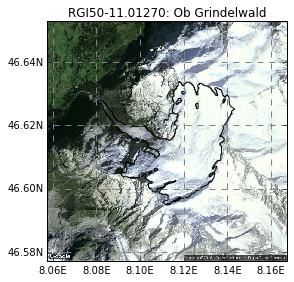

In [6]:
graphics.plot_googlemap(gdir)

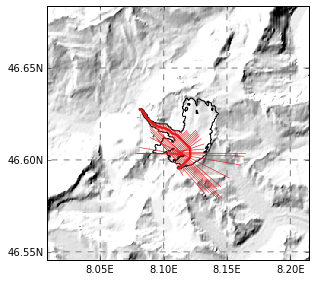

In [13]:
graphics.plot_catchment_width(gdir, corrected=True)

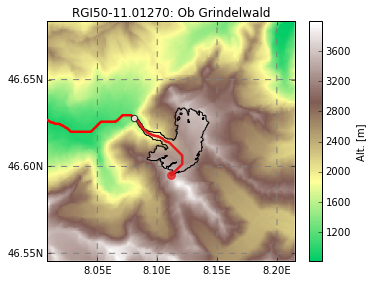

In [14]:
graphics.plot_centerlines(gdir, add_downstream=True)

### By the way, to shich year does this glacier outline correspond?  

In [15]:
gdir.rgi_date

Timestamp('2003-07-01 00:00:00')

### Example: see how well the flowline represents the altitude area distribution of the glacier

In [7]:
# Local topography data
fgrid = gdir.get_filepath('gridded_data')
with netCDF4.Dataset(fgrid) as nc:
    topo = nc.variables['topo_smoothed'][:]
    mask = nc.variables['glacier_mask'][:]

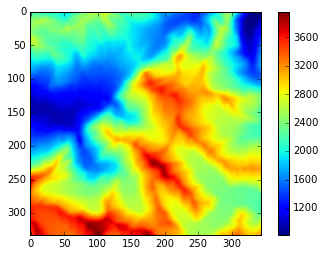

In [8]:
plt.imshow(topo)
plt.colorbar();

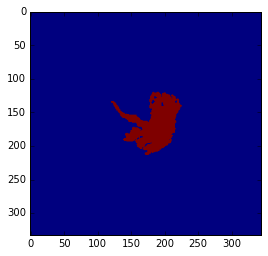

In [9]:
plt.imshow(mask);

In [19]:
# histogram of real glacier
bins = np.arange(1400, 3601, 100)
hist_real, _ = np.histogram(topo[np.nonzero(mask)], bins=bins, density=True)

In [20]:
# Histogram of flowline glacier
fl = gdir.read_pickle('inversion_flowlines')[-1]  # -1 because there is just one flowline
hist, _ = np.histogram(fl.surface_h, weights=fl.widths, bins=bins, density=True)

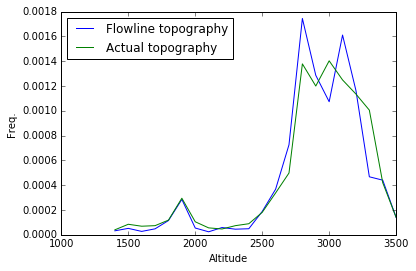

In [21]:
# Plot
plt.plot(bins[:-1], hist, label='Flowline topography')
plt.plot(bins[:-1], hist_real, label='Actual topography')
plt.ylabel('Freq.');
plt.xlabel('Altitude');
plt.legend(loc='best');

### Example: mass-balance data

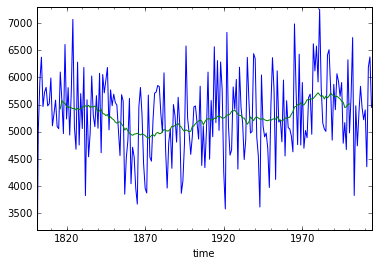

In [22]:
import xarray as xr
d = xr.open_dataset(gdir.get_filepath('climate_monthly'))
annual_prcp = d.prcp.resample(freq='AS', dim='time', how=np.sum).to_series()
ax = annual_prcp.plot();
annual_prcp.rolling(30, center=True).mean().plot();
ax.set_ylim([3200, 7300]);

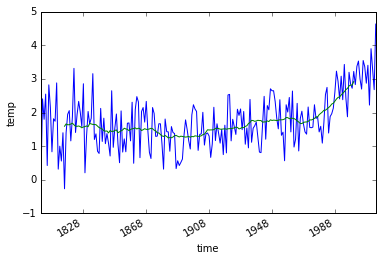

In [23]:
annual_temp = d.temp.resample(freq='AS', dim='time', how=np.mean)
annual_temp.plot();
annual_temp.to_series().rolling(30, center=True).mean().plot();

In [24]:
# t_Star = year at which Grindelwald was in equi, according to oggm. mu_star is temperature sensitivity
pd.read_csv(gdir.get_filepath('local_mustar'))

,rgi_id,t_star,mu_star,bias
0,RGI50-11.01270,1975,355.738294,-16.973493


In [12]:
# We can build a mass-balance model based on these values and climate from HISTALP
mbmod = massbalance.HistalpMassBalanceModel(gdir)

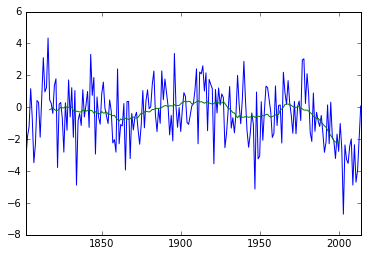

In [26]:
years = np.arange(1802, 2015, 1)
spec_mb = years * 0.
for i, y in enumerate(years):
    mb_onh = mbmod.get_mb(fl.surface_h, year=y) * oggm.cfg.SEC_IN_YEAR
    spec_mb[i] = np.average(mb_onh, weights=fl.widths) 
spec_mb = pd.Series(spec_mb, index=years)
spec_mb.plot();
spec_mb.rolling(30, center=True).mean().plot();

In [27]:
# Check that mass balance around 1975 is approx zero
spec_mb.loc[1960:1990].mean()

1.8639282857670485e-07

### Example: length data from Leclercq

This is a dataset prvided by Paul Leclercq: http://folk.uio.no/paulwl/data.php. Thomas should check it in more details and see if it fits to his own data sources.

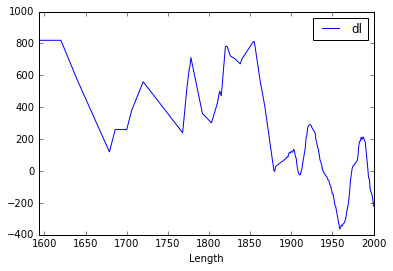

In [28]:
lengths_data = pd.read_csv(utils.get_demo_file('grindelwald_lengths.csv'), index_col=0)
# We plot the entire period:
ax = lengths_data.plot();
ax.set_xlabel('Length');

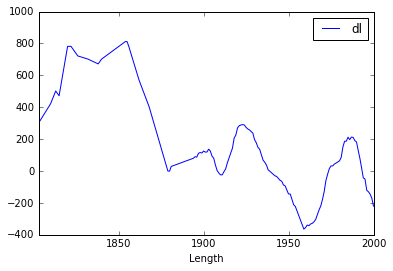

In [29]:
# Plot the last 200 years:
ax = lengths_data.loc[1800:].plot();
ax.set_xlabel('Length');

### Example: compute the bed thickness

In [13]:
glen_a = cfg.A
vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a)
print('With the default A (={}), the mean thickness of Grindelwald is {:.1f} m'.format(glen_a, vol_m3/area_m3))

With the default A (=2.4e-24), the mean thickness of Grindelwald is 56.4 m


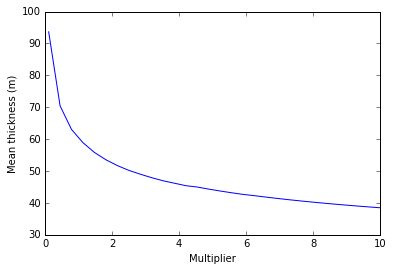

In [32]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
    thick[i] = vol_m3/area_m3
plt.figure(figsize=(6, 4))
plt.plot(factor, thick);
plt.ylabel('Mean thickness (m)');
plt.xlabel('Multiplier');

Explain why it looks like this!

### Try to find out which points corresponds to the location of the GPR measurements (more or less)

Approximate lon, lat of measurements:

In [33]:
lat_ref, lon_ref = 46.617991, 8.098331

Lon, lat along the flowline and closest point (index):

In [34]:
gi, gj = fl.line.xy
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)
distances = np.sqrt((lon_ref - lon)**2 + (lat_ref - lat)**2)
index = np.argmin(distances)

Expected width (from plot by Andreas Bauder): ~ 425 m. Expected thickness: ~ 170 m

473.062643515


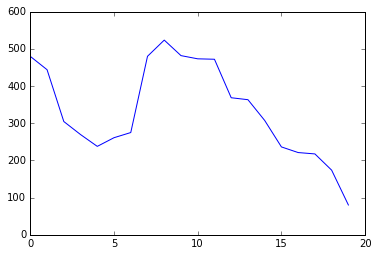

In [35]:
# Plot of the width around the closest point
width_meter = fl.widths * gdir.grid.dx
plt.plot(width_meter[index-10:index+10])
print(width_meter[index])

Ok the the closest point is a good indicator. Let's plot the thickness of our section for several factors:

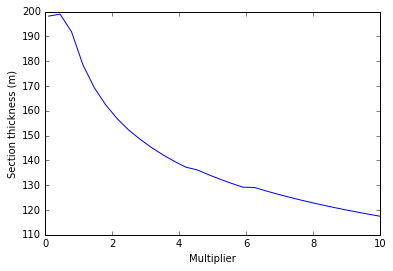

In [36]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
    out = gdir.read_pickle('inversion_output', div_id=1)
    thick[i] = out[0]['thick'][index]  
plt.figure(figsize=(6, 4))
plt.plot(factor, thick);
plt.ylabel('Section thickness (m)');
plt.xlabel('Multiplier');

## Flowline modelling: purely parabolic bed

We are now inverting the ice with a factor 2:

In [14]:
out = invert_parabolic_bed(gdir, glen_a=glen_a*1, write=True)

And preparing the data for the run. `init_present_time_glacier` is taking the data from the inversion and makes model flowlines out of it:

In [15]:
# we keep the bed parabolic everywhere, just like for the inversion
cfg.PARAMS['bed_shape'] = 'parabolic'
flowline.init_present_time_glacier(gdir)

We can read the flowline out of the glacier directory:

In [16]:
fls = gdir.read_pickle('model_flowlines')
fl = fls[0]
fl

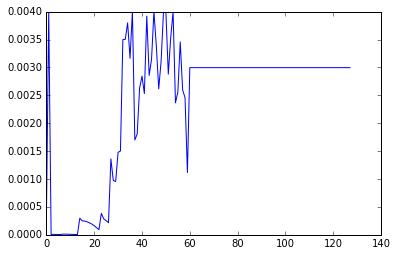

In [40]:
# plot the bed_shape
# it has very low values in the accumulation area, and can have very high values in the tongue
# For the downstream line, the method has picked a standard value
plt.plot(fl.bed_shape);

In [41]:
# origin flowline
u_fl = fls[0]

In [42]:
# now make a model run with today's climate for a 100 years (a so-called "commitment" run)
mb_mod = massbalance.TodayMassBalanceModel(gdir)
# note the call to deepcopy() - this is important! 
model = flowline.FluxBasedModel(copy.deepcopy(u_fl), mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*2)
model.run_until(100)

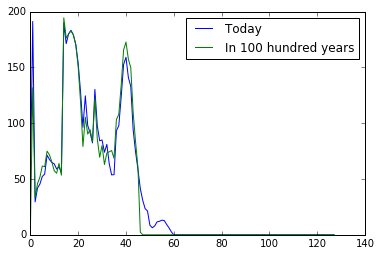

In [43]:
# plot the thickness
plt.plot(u_fl.thick, label='Today')
plt.plot(model.fls[0].thick, label='In 100 hundred years');
plt.legend(loc='best');

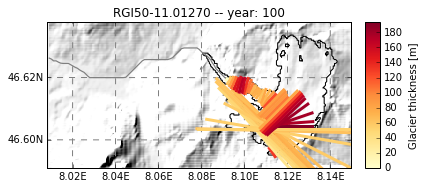

In [44]:
graphics.plot_modeloutput_map(gdir, model=model)

In [45]:
# "BackwardsMassBalanceModel" is a model I developped to help me to grow glaciers
# Here we use it just for illustration
# now add a temperature bias of 2°C to today's climate 
# The bias unit is in hundredths of degree, and of negative sign (sorry for that)
mb_mod = massbalance.BackwardsMassBalanceModel(gdir, bias=200)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*2)
model.run_until_equilibrium()

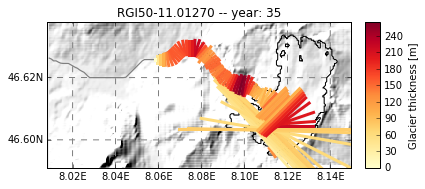

In [46]:
# How does it look like?
graphics.plot_modeloutput_map(gdir, model=model)

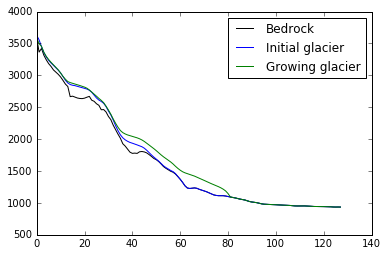

In [47]:
plt.plot(u_fl.bed_h, color='k', label='Bedrock')
plt.plot(u_fl.surface_h, label='Initial glacier')
plt.plot(model.fls[0].surface_h, label='Growing glacier')
plt.legend(loc='best');

### Now with real climate forcing

In [48]:
# we now use the actual Histalp mass balance to run the model
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
# Now we are using "real time", so we have to define the starting year accordingly
y_start = 1879  # I take 1879 because this is a year of length 0 in the ref
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=y_start, fs=0., glen_a=glen_a)

In [49]:
# For every year where we have an observation, we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m

In [50]:
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]

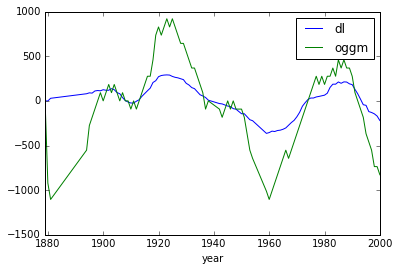

In [51]:
# Make a plot of it
ref_data.plot();

Analyse the plot. What is working well, what is not? 

### Now we change the bed shape after the tongue to make it flat 

In [52]:
# Make it flat
u_fl = copy.deepcopy(fls[0])
u_fl.bed_shape[60:] = 0.0001

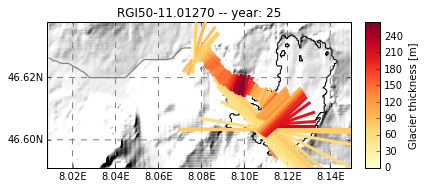

In [53]:
#  See how a bigger glacier looks like
mb_mod = massbalance.BackwardsMassBalanceModel(gdir, bias=200)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*2)
model.run_until_equilibrium()
graphics.plot_modeloutput_map(gdir, model=model)

In [54]:
# we now use the actual Histalp mass balance to run the model on the flat tongue
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
y_start = 1879  # I take 1879 because this is a year of length 0 in the ref
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=y_start, fs=0., glen_a=glen_a)

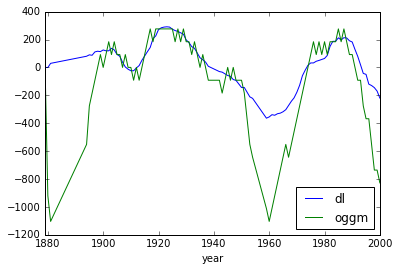

In [55]:
# For every year where we have an observation, we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();

Ok so now we have very realistic advances, but very strong retreats. What could be the reason(s)?

## U-shaped glacier 

the results of the parabolic glacier are actually quite good, but let's try a u shaped glacier for fun

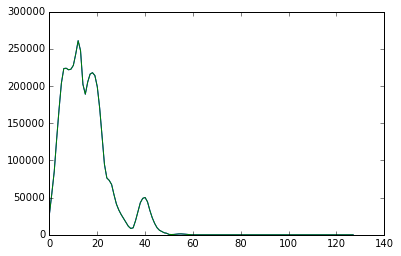

In [56]:
fls = gdir.read_pickle('model_flowlines')
fl = fls[0]
# Now we are going to compute the area of each section (this has to be conserved):
section = 2. / 3 * fl.widths_m * (fl.surface_h - fl.bed_h)
plt.plot(section);
plt.plot(fl.section)

In [51]:
# ok, now make a U shaped bed everywhere 
# where widths are zero - below the current tongue - I set to 30 units (units * fl.map_dx = real width)
bed_h = np.where(fl.widths_m > 0, fl.surface_h - section/fl.widths_m, fl.bed_h)
widths = np.where(fl.widths > 0, fl.widths, 30)
u_fl = flowline.VerticalWallFlowline(line=fl.line, dx=fl.dx, map_dx=fl.map_dx,
                                     surface_h=fl.surface_h, widths=widths,
                                     bed_h=bed_h)
# check
assert np.isclose(u_fl.volume_km3, fl.volume_km3)

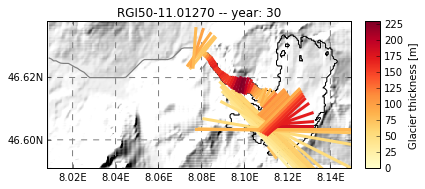

In [52]:
#  See how a bigger glacier looks like
mb_mod = massbalance.BackwardsMassBalanceModel(gdir, bias=200)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=0., fs=0., glen_a=glen_a*2)
model.run_until_equilibrium()
graphics.plot_modeloutput_map(gdir, model=model)

In [53]:
# we now use the actual Histalp mass balance to run the model on the flat tongue
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
y_start = 1879  # I take 1879 because this is a year of length 0 in the ref
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=y_start, fs=0., glen_a=glen_a)

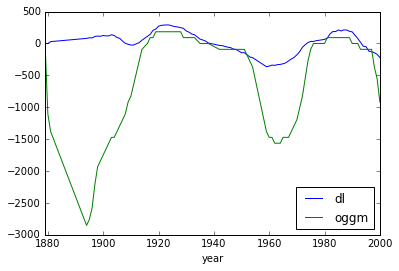

In [54]:
# For every year where we have an observation, we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m
# add oggm time series to the relative length
ref_data['oggm'] = length - length[0]
# Make a plot of it
ref_data.plot();

The tongue retreat is even stronger than with the parabolic bed!